In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import repeat, product
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


# to disable ssl certificate check...
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

work_path = '/cluster/raid/home/f80878961/agripol/'


Matplotlib created a temporary cache directory at /tmp/matplotlib-qbrx0qyy because the default path (/software/anaconda3/envs/eb/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Parse and clean tables

## ColEval

In [2]:
coleval_data_fn = '{}agripol_coleval_clean_20231228 unprotect_corrected.xlsx'.format(work_path)

dfs = pd.read_excel(coleval_data_fn, sheet_name=None, engine='openpyxl')
dfs.keys()

dict_keys(['coleval_2018', 'coleval_2019', 'coleval_2020', 'coleval_2021', 'coleval_2022', 'coleval_2023', 'codeboook'])

In [3]:
coleval_df = pd.concat(
    [dfs['coleval_2018'].iloc[:, :22],
    dfs['coleval_2019'].iloc[:, :22].rename(columns={'anneeRuche2': 'anneeRuche'}),
    dfs['coleval_2020'].iloc[:, :22].rename(columns={'anneeRuche3': 'anneeRuche'}),
    dfs['coleval_2021'].iloc[:, :22].rename(columns={'anneeRuche4': 'anneeRuche'}),
    dfs['coleval_2022'].iloc[:, :22].rename(columns={'anneeRuche5': 'anneeRuche'}),
    dfs['coleval_2023'].iloc[:, :22].rename(columns={'anneeRuche4': 'anneeRuche'})]
)

In [4]:
# drop rows with Not a Time (NaT) value as mostly no informative rows
coleval_df = coleval_df[~coleval_df['datecoleval'].isna()]

print(set(coleval_df['visites']))
print(set(coleval_df['coderucher']))
print(set(coleval_df['numruche']))
print(set(coleval_df['year']))

{'v1', 'v3', 'v2', 'v4'}
{'R26', 'R28', 'R19', 'R01', 'R28b', 'R03', 'R23', 'R13', 'R18b', 'R08', 'R16', 'R27', 'R10', 'R06', 'R14', 'R12b', 'R18', 'R15', 'R30', 'R21', 'R25', 'R21b', 'R07', 'R05', 'R02', 'R20', 'R04', 'R24', 'R29', 'R24b', 'R22', 'R22b', 'R09', 'R17', 'R11', 'R12'}
{'C02', 'C06', 'C10', 'C03', 'C01', 'C08', 'C09', 'C04', 'C07', 'C05'}
{2018, 2019, 2020, 2021, 2022, 2023}


In [5]:
# new ideval that should yield unique values
def new_ideval(row):
    return ''.join([str(row['visites']), str(row['coderucher']), str(row['numruche']), str(row['datecoleval'].year)]).upper()

coleval_df.insert(0, 'new_ideval', coleval_df.apply(new_ideval, axis=1))

- often wrong date (all 2020 that should be 2021 or..)
- drop NaT datacoleval

In [6]:
# assert unique ids!
assert len(set(coleval_df['new_ideval'])) == len(coleval_df)

## Varroa Phoretic (VP) 

In [7]:
vp_2018_2022_fn = '{}agripol_vp_1819202122_20241023.xlsx'.format(work_path)
vp_2023_v1 = '{}Agripol_VP_2023_v1.xlsx'.format(work_path)
vp_2023_v2 = '{}Agripol_VP_2023_v2.xlsx'.format(work_path)
vp_2023_v3 = '{}Agripol_VP_2023_V3.xlsx'.format(work_path)
vp_2023_v4 = '{}Agripol_VP_2023_V4.xlsx'.format(work_path)


In [8]:
dfs = pd.read_excel(vp_2018_2022_fn, sheet_name=None, engine='openpyxl')
vp_2018_2022_df = dfs['Sheet 1']

In [9]:
dfs = pd.read_excel(vp_2023_v1, sheet_name=None, engine='openpyxl')
vp_2023_v1_df = dfs['VP_2022_v1']
vp_2023_v1_df_clean = vp_2023_v1_df.iloc[8:, 1:20]
vp_2023_v1_df_clean.columns = vp_2023_v1_df.iloc[7, 1:20].to_list()

In [10]:
dfs = pd.read_excel(vp_2023_v2, sheet_name=None, engine='openpyxl')
vp_2023_v2_df = dfs['VP_2022_v1']
vp_2023_v2_df_clean = vp_2023_v2_df.iloc[8:, 1:20]
vp_2023_v2_df_clean.columns = vp_2023_v2_df.iloc[7, 1:20].to_list()

In [11]:
dfs = pd.read_excel(vp_2023_v3, sheet_name=None, engine='openpyxl')
vp_2023_v3_df = dfs['VP_2023_V3']
vp_2023_v3_df_clean = vp_2023_v3_df.iloc[8:, 1:20]
vp_2023_v3_df_clean.columns = vp_2023_v3_df.iloc[7, 1:20].to_list()

In [12]:
dfs = pd.read_excel(vp_2023_v4, sheet_name=None, engine='openpyxl')
vp_2023_v4_df = dfs['VP_2023_V4']
vp_2023_v4_df_clean = vp_2023_v4_df.iloc[8:, 1:20]
vp_2023_v4_df_clean.columns = vp_2023_v4_df.iloc[7, 1:20].to_list()

In [13]:
print(vp_2023_v1_df_clean.shape)
print(vp_2023_v2_df_clean.shape)
print(vp_2023_v3_df_clean.shape)
print(vp_2023_v4_df_clean.shape)

(301, 19)
(301, 19)
(301, 19)
(301, 19)


In [14]:
vp_2023_df = pd.concat([vp_2023_v1_df_clean, vp_2023_v2_df_clean, vp_2023_v3_df_clean, vp_2023_v4_df_clean])

actually we don't need 2023... maybe latter

In [15]:
vp_df = pd.concat([vp_2018_2022_df.loc[:, ['ideval', 'coderucher', 'year', 'numruche', 'vis', 'vp.100ab']].rename(columns={'vp.100ab':'vp/100ab', 'vis': 'visites'}), 
                   vp_2023_df.loc[:, ['ideval', 'coderucher', 'year', 'numruche', 'visites', 'vp/100ab']]])

In [16]:
# drop row without visit info for now
vp_df = vp_df[~vp_df['visites'].isna()]

# add missing V
def rename_visites(row):
    v = str(row['visites'])
    if not v.startswith('V'):
        v = 'V{}'.format(v)
    return v
    
vp_df['visites'] = vp_df.apply(rename_visites, axis=1)

In [17]:
set(vp_df['visites'])

{'V1', 'V2', 'V3', 'V4'}

In [18]:
# new ideval that should yield unique values
def new_ideval(row):
    return ''.join([str(row['visites']), str(row['coderucher']), str(row['numruche']), str(row['year'])]).upper()

vp_df.insert(0, 'new_ideval', vp_df.apply(new_ideval, axis=1))

In [19]:
vp_df

,new_ideval,ideval,coderucher,year,numruche,visites,vp/100ab
0,V1R01C012018,V1R01C012018,R01,2018,C01,V1,NaN
1,V2R01C012018,V2R01C012018,R01,2018,C01,V2,3.100645
2,V3R01C012018,V3R01C012018,R01,2018,C01,V3,3.537755
3,V4R01C012018,V4R01C012018,R01,2018,C01,V4,3.991047
4,V1R01C012019,V1R01C012019,R01,2019,C01,V1,0.0
...,...,...,...,...,...,...,...
300,V4R30C022023,V4R30C022023,R30,2023,C02,V4,1.376104
301,V4R30C032023,V4R30C032023,R30,2023,C03,V4,2.879377
302,V4R30C042023,V4R30C042023,R30,2023,C04,V4,2.322479
303,V4R30C052023,V4R30C052023,R30,2023,C05,V4,0.76328


In [20]:
# assert uniqueness of new coleval id
assert len(set(vp_df['new_ideval'])) == len(vp_df)

## Pathogens

In [21]:
pathogen_data_fn = '{}Agripol all pathogen data beta Actin complet to use for stats.xlsx'.format(work_path)

dfs = pd.read_excel(pathogen_data_fn, sheet_name=None, engine='openpyxl')
dfs.keys()

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/

dict_keys(['Runs 2018', 'Runs 2019', 'Runs 2020', 'Runs 2021', 'Runs 2022', 'missing bactin'])

In [22]:
def clean_df(df, pathogens, apis_col, βActin_col):
    '''
    custom function to clean agripol pathogen excel file
    '''
    p2cols = defaultdict(list)
    columns = []
    curr_pathogen = None
    for c in df.columns:
        if c in pathogens:
            curr_pathogen = c
        if curr_pathogen and c not in {apis_col, βActin_col}:
            p2cols[curr_pathogen].append(c)
            columns.append(c)
    
    new_cols = []
    for p, cols in p2cols.items():
        assert len(cols) >1 & len(cols) <4
        
        # ct and detected?
        if len(cols) == 2:
            new_cols.extend(['{} Ct value'.format(p), '{} Detected'.format(p)])
        
        # ct, delta ct , and detected
        else:
            new_cols.extend(['{} Ct value'.format(p), '{} delta Ct'.format(p), '{} Detected'.format(p)])
    
    assert len(columns) == len(new_cols)

    return df, columns, new_cols

2018

get pathogen names from this first table

In [23]:
year = 2018
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'βActin RT'

In [24]:
df = dfs['Runs {}'.format(year)]
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)',
       'Melissococcus plutonius', 'Unnamed: 11', 'Paenibacillus larvae',
       'Unnamed: 13', 'Ascosphera', 'Unnamed: 15', 'Nosema ceranae',
       'Unnamed: 17', 'Nosema apis', 'Unnamed: 19', 'βActin RT', 'DWV A',
       'Unnamed: 22', 'DWV B', 'Unnamed: 24', 'Unnamed: 25', 'DWV C',
       'Unnamed: 27', 'Unnamed: 28', 'SBV', 'Unnamed: 30', 'Unnamed: 31',
       'BCQV', 'Unnamed: 33', 'Unnamed: 34', 'ABPV', 'Unnamed: 36',
       'Unnamed: 37', 'KBV', 'Unnamed: 39', 'Unnamed: 40', 'IAPV',
       'Unnamed: 42', 'Unnamed: 43'],
      dtype='object')

In [25]:
pathogens = []
for c in df:
    if not c.startswith('Unnamed') and c not in {apis_col, βActin_col}:
        pathogens.append(c)

assert len(pathogens) == 13
pathogens

['Melissococcus plutonius',
 'Paenibacillus larvae',
 'Ascosphera',
 'Nosema ceranae',
 'Nosema apis',
 'DWV A',
 'DWV B',
 'DWV C',
 'SBV',
 'BCQV',
 'ABPV',
 'KBV',
 'IAPV']

In [26]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', apis_col, βActin_col]
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite', 'Apis mellifera Ct value', 'βActin RT']
for i, oc in enumerate(other_columns[:5]):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [27]:
# skip first row and rows without qPCR values
df_2018 = df.loc[1:788, other_columns + columns]
df_2018.columns = other_columns_new_names + new_cols

# filter rows without Rucher, Colonie, etc. even if there are PCR values ?

2019

In [28]:
year = 2019
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'β-Actin RT run no 200824 1+2 et 2008243'

df = dfs['Runs {}'.format(year)]
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', apis_col, βActin_col]
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite', 'Apis mellifera Ct value', 'βActin RT']
for i, oc in enumerate(other_columns[:5]):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [29]:
# skip first row and rows without qPCR values
df_2019 = df.loc[1:1076, other_columns + columns]
df_2019.columns = other_columns_new_names + new_cols

2020

- no IAPV

In [30]:
year = 2020
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [31]:
df = dfs['Runs {}'.format(year)]

In [32]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'}).drop('Unnamed: 46', axis=1)

In [33]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', apis_col, βActin_col]
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite', 'Apis mellifera Ct value', 'βActin RT']
for i, oc in enumerate(other_columns[:5]):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [34]:
# skip first row and rows without qPCR values
df_2020 = df.loc[1:934, other_columns + columns]
df_2020.columns = other_columns_new_names + new_cols

2021

In [35]:
year = 2021
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [36]:
df = dfs['Runs {}'.format(year)]

In [37]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'})

In [38]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', apis_col, βActin_col]
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite', 'Apis mellifera Ct value', 'βActin RT']
for i, oc in enumerate(other_columns[:5]):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [39]:
# skip first row and rows without qPCR values
df_2021 = df.loc[1:951, other_columns + columns]
df_2021.columns = other_columns_new_names + new_cols

2022

- no ABPV, KBV, IAPV, which are strains of KIABPV --> assumption KIABPV = IAPV as no ABPV and KBV in 2018-2021

In [40]:
year = 2022
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [41]:
df = dfs['Runs {}'.format(year)]

In [42]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema Apis':'Nosema apis', 'KIABPV' : 'ABPV'}).drop('Ct values for ABPV, KBV IAPV not available this year', axis=1)

In [43]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', apis_col, βActin_col]
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite', 'Apis mellifera Ct value', 'βActin RT']
for i, oc in enumerate(other_columns[:5]):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [44]:
# skip first row and rows without qPCR values
df_2022 = df.loc[1:957, other_columns + columns]
df_2022.columns = other_columns_new_names + new_cols

Merge datasets

In [45]:
print(df_2018.shape)
print(df_2019.shape)
print(df_2020.shape)
print(df_2021.shape)
print(df_2022.shape)

(788, 40)
(1076, 41)
(934, 38)
(951, 41)
(957, 31)


In [46]:
print(set(df_2019.columns).difference(df_2018))
print(set(df_2019.columns).difference(df_2020))
print(set(df_2019.columns).difference(df_2021))
print(set(df_2019.columns).difference(df_2022))

{'DWV A delta Ct'}
{'IAPV Detected', 'IAPV delta Ct', 'IAPV Ct value'}
set()
{'KBV delta Ct', 'IAPV Detected', 'IAPV Ct value', 'SBV Detected', 'KBV Detected', 'SBV delta Ct', 'ABPV delta Ct', 'KBV Ct value', 'IAPV delta Ct', 'SBV Ct value'}


In [47]:
df_patho = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [48]:
# drop row without visit info for now
df_patho = df_patho[~df_patho['Visite'].isna()]

# and rows without correct datetime object
df_patho = df_patho[df_patho['Date'].apply(lambda x: isinstance(x, datetime.datetime))]

In [49]:
# new ideval that should yield unique values
def new_ideval(row):
    return ''.join([str(row['Visite']), str(row['Rucher']), str(row['Colonie']), str(row['Date'].year)]).upper()

df_patho.insert(0, 'new_ideval', df_patho.apply(new_ideval, axis=1))

In [50]:
df_patho = df_patho.reset_index()

In [51]:
df_patho[df_patho['new_ideval'].duplicated()]

,index,new_ideval,N° tube,Rucher,Colonie,Date,Visite,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
3834,4110,V4R23C052022,362,R23,C05,2022-10-07 00:00:00,V4,25.35,NaN,flat,-,flat,-,31.25,-,28.91,-,36.64,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,26.72,NaN,-,31.51,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_patho[df_patho['new_ideval'] == 'V4R23C052022']

,index,new_ideval,N° tube,Rucher,Colonie,Date,Visite,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
2147,2380,V4R23C052022,517,R23,C05,2022-10-19 00:00:00,V4,27.41,NaN,flat,-,flat,-,33.37,-,25.87,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,28.7,NaN,-,26.68,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,NaN
3834,4110,V4R23C052022,362,R23,C05,2022-10-07 00:00:00,V4,25.35,NaN,flat,-,flat,-,31.25,-,28.91,-,36.64,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,26.72,NaN,-,31.51,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_patho = df_patho.drop([3834]).reset_index()

In [54]:
# assert uniqueness of new coleval id
assert len(set(df_patho['new_ideval'])) == len(df_patho)

In [55]:
df_patho

,level_0,index,new_ideval,N° tube,Rucher,Colonie,Date,Visite,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
0,0,0,V4R27C052018,1,R27,C05,2018-10-23 00:00:00,V4,25.33,flat,flat,-,37.27,-,26.73,-,flat,-,flat,-,flat,-,30.8,NaN,+,NaN,NaN,-,28.58,NaN,-,28.32,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
1,1,1,V4R08C042018,2,R08,C04,2018-10-26 00:00:00,V4,25.13,NaN,flat,-,36.27,-,26.47,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,29.65,NaN,-,28.77,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
2,2,2,V4R17C042018,3,R17,C04,2018-10-17 00:00:00,V4,25.31,NaN,flat,-,31.66,-,26.74,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.43,NaN,-,28.08,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
3,3,4,V4R04C072018,5,R04,C07,2018-10-18 00:00:00,V4,26,28.91,flat,-,33.91,-,27.16,-,22.76,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,30.68,NaN,-,31.66,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
4,4,5,V4R20C062018,6,R20,C06,2018-10-15 00:00:00,V4,25.52,NaN,flat,-,36.89,-,26.39,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,30.91,NaN,-,29.74,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,4412,4701,V1R20C052022,953,R20,C05,2022-04-12 00:00:00,V1,26.65,NaN,flat,-,flat,-,34.07,-,25.06,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,27.19,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4412,4413,4702,V1R20C062022,954,R20,C06,2022-04-12 00:00:00,V1,27.36,NaN,flat,-,flat,-,36.99,-,21.04,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,flat,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4413,4414,4703,V1R20C072022,955,R20,C07,2022-04-12 00:00:00,V1,25.76,22.59,flat,-,flat,-,32.66,-,21.26,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,flat,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4414,4415,4704,V1R20C092022,956,R20,C09,2022-04-12 00:00:00,V1,27.53,22.33,flat,-,flat,-,34.34,-,22.58,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,30,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge all

In [56]:
vp_df

,new_ideval,ideval,coderucher,year,numruche,visites,vp/100ab
0,V1R01C012018,V1R01C012018,R01,2018,C01,V1,NaN
1,V2R01C012018,V2R01C012018,R01,2018,C01,V2,3.100645
2,V3R01C012018,V3R01C012018,R01,2018,C01,V3,3.537755
3,V4R01C012018,V4R01C012018,R01,2018,C01,V4,3.991047
4,V1R01C012019,V1R01C012019,R01,2019,C01,V1,0.0
...,...,...,...,...,...,...,...
300,V4R30C022023,V4R30C022023,R30,2023,C02,V4,1.376104
301,V4R30C032023,V4R30C032023,R30,2023,C03,V4,2.879377
302,V4R30C042023,V4R30C042023,R30,2023,C04,V4,2.322479
303,V4R30C052023,V4R30C052023,R30,2023,C05,V4,0.76328


In [57]:
coleval_vp_df = pd.merge(coleval_df, vp_df[['new_ideval', 'vp/100ab']], on='new_ideval', how='left')

In [58]:
df_patho[['new_ideval'] + list(df_patho.columns[8:])]

,new_ideval,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
0,V4R27C052018,25.33,flat,flat,-,37.27,-,26.73,-,flat,-,flat,-,flat,-,30.8,NaN,+,NaN,NaN,-,28.58,NaN,-,28.32,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
1,V4R08C042018,25.13,NaN,flat,-,36.27,-,26.47,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,29.65,NaN,-,28.77,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
2,V4R17C042018,25.31,NaN,flat,-,31.66,-,26.74,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.43,NaN,-,28.08,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
3,V4R04C072018,26,28.91,flat,-,33.91,-,27.16,-,22.76,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,30.68,NaN,-,31.66,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
4,V4R20C062018,25.52,NaN,flat,-,36.89,-,26.39,-,flat,-,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,30.91,NaN,-,29.74,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,V1R20C052022,26.65,NaN,flat,-,flat,-,34.07,-,25.06,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,27.19,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4412,V1R20C062022,27.36,NaN,flat,-,flat,-,36.99,-,21.04,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,flat,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4413,V1R20C072022,25.76,22.59,flat,-,flat,-,32.66,-,21.26,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,flat,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4414,V1R20C092022,27.53,22.33,flat,-,flat,-,34.34,-,22.58,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,30,NaN,-,flat,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
all_df = pd.merge(coleval_vp_df, df_patho[['new_ideval'] + list(df_patho.columns[8:])], on='new_ideval', how='left')

In [60]:
all_df.to_csv('{}all_df.csv'.format(work_path), index=False)

# Cluster samples by presence absence of pathogens

In [61]:
pathogens = ['Melissococcus plutonius',
 'Paenibacillus larvae',
 'Ascosphera',
 'Nosema ceranae',
 'Nosema apis',
 'DWV A',
 'DWV B',
 'DWV C',
 'SBV',
 'BCQV',
 'ABPV',
 'KBV',
 'IAPV']

In [62]:
df_all = pd.read_csv('{}all_df.csv'.format(work_path))

In [63]:
pathogen_nr = [0] * len(df_all)

df_prev_rows = [list] * len(df_all)
# df_abun_rows = [] * len(df_2019)

for i in range(len(df_all)):
    row = [0] * len(pathogens)
    for j, p in enumerate(pathogens):
        if df_all.iloc[i, df_all.columns.get_loc('{} Detected'.format(p))] == '+':
            pathogen_nr[i] += 1
            row[j] = 1
    df_prev_rows[i] = row

In [64]:
df_prev = pd.DataFrame(df_prev_rows, columns=pathogens)

In [65]:
df_prev.sum(axis=0)

Melissococcus plutonius       1
Paenibacillus larvae          2
Ascosphera                  196
Nosema ceranae             2695
Nosema apis                  64
DWV A                        13
DWV B                       268
DWV C                         0
SBV                          42
BCQV                         91
ABPV                        276
KBV                           0
IAPV                          0
dtype: int64

In [66]:
# cg = sns.clustermap(df_prev, metric='jaccard', col_cluster=False)

/tmp/ipykernel_133903/2600048935.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


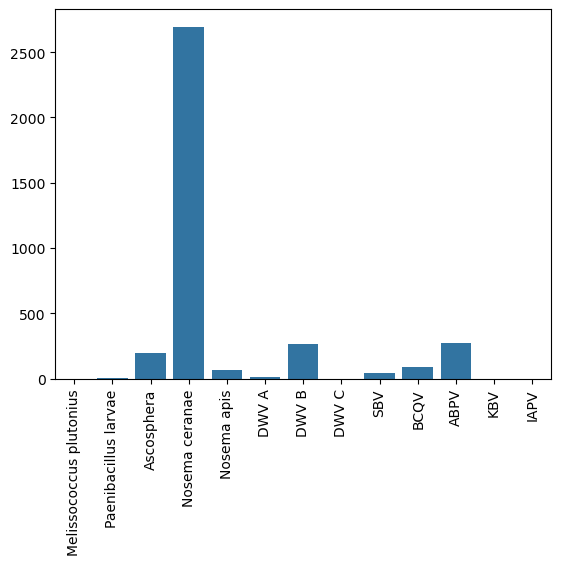

In [67]:
ax = sns.barplot(df_prev.sum(axis=0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [68]:
min_patho_nr = 3
df_prev_filtered = df_prev[df_prev.sum(axis=1) >= min_patho_nr].drop(columns=df_prev.columns[df_prev.sum(axis=0) == 0])

In [69]:
df_prev_filtered.shape

(110, 10)

/tmp/ipykernel_133903/2880208192.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


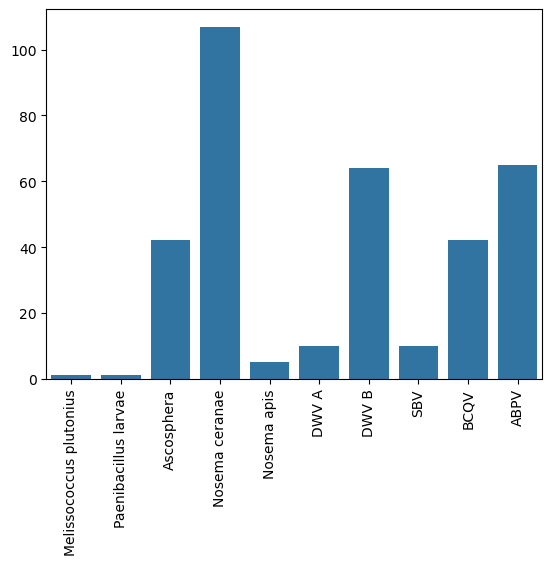

In [70]:
ax = sns.barplot(df_prev_filtered.sum(axis=0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

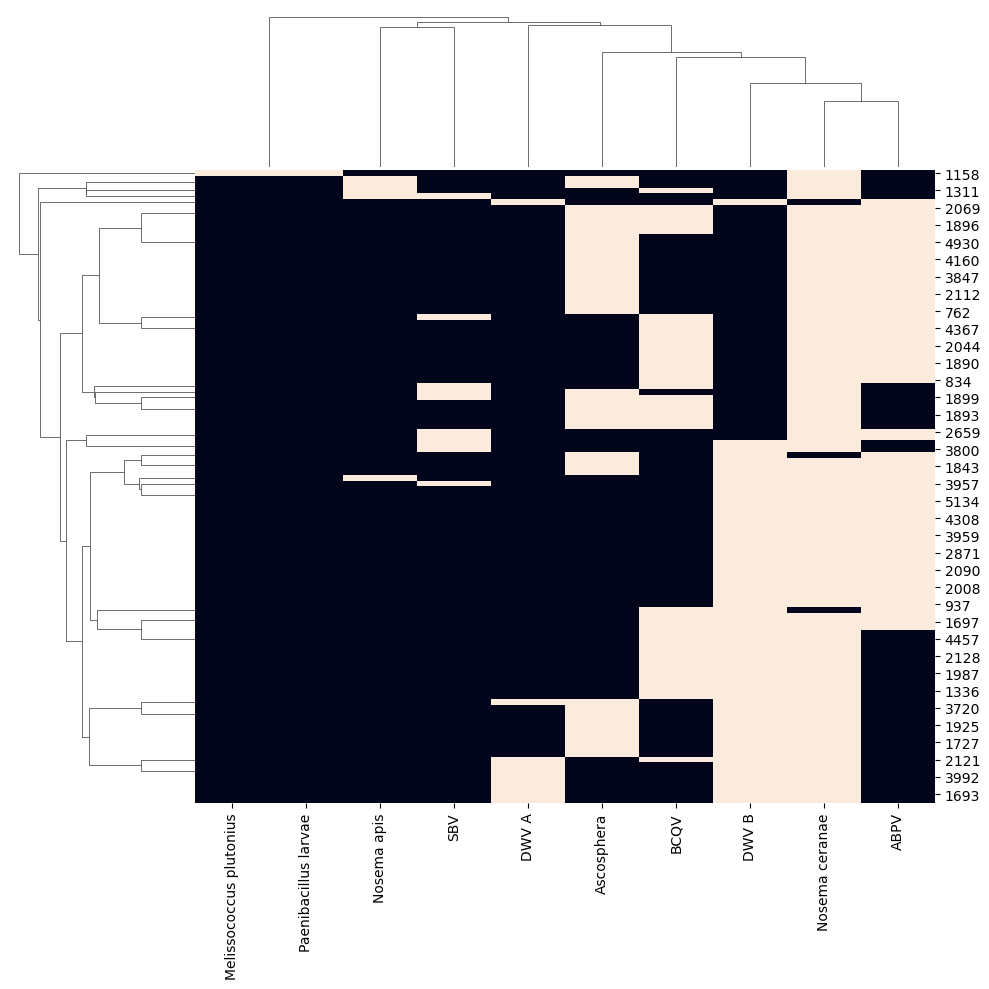

In [71]:
cg = sns.clustermap(df_prev_filtered, metric='jaccard', col_cluster=True)
cg.cax.set_visible(False)

## old

In [259]:
clustered_rows = np.array(df_prev_filtered.index[cg.dendrogram_row.reordered_ind])

In [260]:
# new index clustered
new_idx_clustered = np.array(cg.dendrogram_row.reordered_ind)

# reorder table accordingly
df_prev_filtered_clust = df_prev_filtered.iloc[new_idx_clustered, :]

In [261]:
original_index = 1290 # bacteria
original_index = 3496
original_index = 1411
original_index = 3784

idx = np.argwhere(df_prev_filtered_clust.index == original_index).flatten()[0]
idx

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
rge = 5

In [46]:
left_p = (idx - rge) if idx > rge else 0
right_p = (idx + rge) if (idx + rge) < len(df_prev_filtered) else len(df_prev_filtered)
zoom_df = df_prev_filtered_clust.iloc[left_p : right_p, :]
zoom_df

,Melissococcus plutonius,Paenibacillus larvae,Ascosphera,Nosema ceranae,Nosema apis,DWV A,DWV B,SBV,BCQV,ABPV
1670,0,0,1,1,0,0,1,0,0,0
1499,0,0,1,1,0,0,1,0,0,0
1471,0,0,1,1,0,0,1,0,0,0
1377,0,0,1,1,0,0,1,0,0,0
1405,0,0,1,1,0,0,1,0,0,0
3784,0,0,0,0,0,0,1,0,1,1
3790,0,0,0,0,0,0,1,0,1,1
3546,0,0,0,1,0,0,1,0,1,1
1613,0,0,0,1,0,0,1,0,1,1
2788,0,0,0,1,0,0,1,0,1,1


<Axes: >

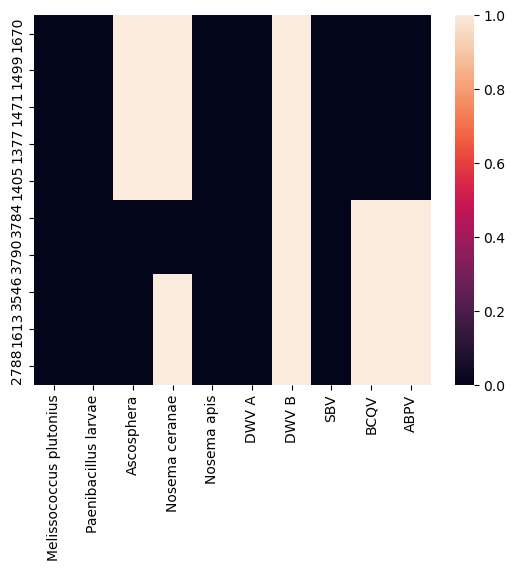

In [47]:
sns.heatmap(zoom_df)

In [70]:
df_all[original_index:original_index+1]

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
3784,36,R20,C03,2022-07-19 00:00:00,V3,flat,-,flat,-,25.31,-,25,-,34.69,-,33.08,-,13.09,11.6,+,31.02,NaN,-,NaN,NaN,NaN,22.555,2.135,+,28.75,NaN,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
patho_row = df_all[original_index:original_index+1]

In [95]:
'V1'.lower()

'v1'

In [96]:
coleval_df[
    (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
    (coleval_df['year'] == patho_row.iloc[0, 3].year) &
    (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
    (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
]

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
792,v3R20C032022,R20,2022,C03,2021.0,2022-07-19,v3,am,Jud Marcel,D,D,0.0,colonie,375.0,0.0,9562.5,425.0,17000.0,300.0,34.02,255.0,28.917


In [78]:
patho_row.loc[:, 'Rucher']

3784    R20
Name: Rucher, dtype: object

In [97]:
def get_coleval_row(coleval_df, patho_row):
    return coleval_df[
        (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
        (coleval_df['year'] == patho_row.iloc[0, 3].year) &
        (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
        (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
        ]

In [118]:
original_index = 1290 # bacteria
# original_index = 3496
# original_index = 1411
# original_index = 3784

In [115]:
patho_row  = df_all[original_index:original_index+1]

In [116]:
patho_row

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
1290,503,R16,C09,2019-04-23 00:00:00,V1,27.475,+,18.99,+,27.495,-,25.27,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.36,NaN,-,flat,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN


In [117]:
coleval_df[
        (coleval_df['coderucher'] == patho_row.iloc[0, 1]) & 
        (coleval_df['year'] == 2020) &
        (coleval_df['numruche'] == patho_row.iloc[0, 2]) &
        (coleval_df['visites'] == patho_row.iloc[0, 4].lower())
        ]

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
158,v1R16C092020,R16,2020,C09,2018.0,2020-04-15,v1,pm,cedric,D,NaN,0.0,colonie,345.0,0.0,8797.5,200.0,8000.0,185.0,20.979,50.0,5.67


In [119]:
get_coleval_row(coleval_df, df_all[original_index:original_index+1])

,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen
158,v1R16C092019,R16,2019,C09,2018.0,2019-04-23,v1,pm,cedric,D,NaN,0.0,colonie,190.0,0.0,4845.0,220.0,8800.0,95.0,10.773,100.0,11.34


In [ ]:
patho_row 

TO DO:
-  validate I understood correctly these tables...
- 
-  understand clusters
-  think abundances (how treat absences, mask value when absent)


# Sample selections

In [72]:
mp_df = df_all[~df_all['Melissococcus plutonius Ct value'].isin({'flat', 'flat !', np.nan, 'X'})]

mp_df['Melissococcus plutonius Ct value'] = np.array(mp_df['Melissococcus plutonius Ct value'].to_numpy(), dtype=float)

/tmp/ipykernel_133903/3498131122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_df['Melissococcus plutonius Ct value'] = np.array(mp_df['Melissococcus plutonius Ct value'].to_numpy(), dtype=float)


<Axes: xlabel='Melissococcus plutonius Ct value', ylabel='Count'>

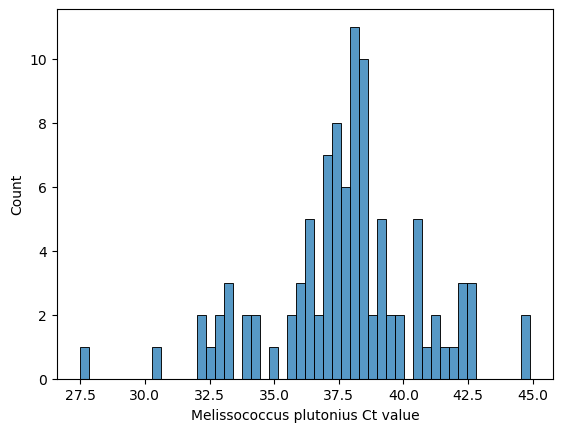

In [73]:
sns.histplot(mp_df['Melissococcus plutonius Ct value'], bins=50)

In [74]:
mp_high = mp_df[mp_df['Melissococcus plutonius Ct value'] < 30].index.to_numpy()
mp_med = mp_df[(mp_df['Melissococcus plutonius Ct value'] > 30) & (mp_df['Melissococcus plutonius Ct value'] < 33)].index.to_numpy()
mp_low = mp_df[(mp_df['Melissococcus plutonius Ct value'] > 35) & (mp_df['Melissococcus plutonius Ct value'] < 38)].index.to_numpy()

In [75]:
dwvb_df = df_all[~df_all['DWV B Ct value'].isin({'flat', 'flat ', 'flat !', np.nan, 'X'})]

dwvb_df['DWV B Ct value'] = np.array(dwvb_df['DWV B Ct value'].to_numpy(), dtype=float)
dwvb_df['DWV B delta Ct'] = np.array(dwvb_df['DWV B delta Ct'].to_numpy(), dtype=float)

/tmp/ipykernel_133903/776051710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwvb_df['DWV B Ct value'] = np.array(dwvb_df['DWV B Ct value'].to_numpy(), dtype=float)
/tmp/ipykernel_133903/776051710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwvb_df['DWV B delta Ct'] = np.array(dwvb_df['DWV B delta Ct'].to_numpy(), dtype=float)


<Axes: xlabel='DWV B Ct value', ylabel='Count'>

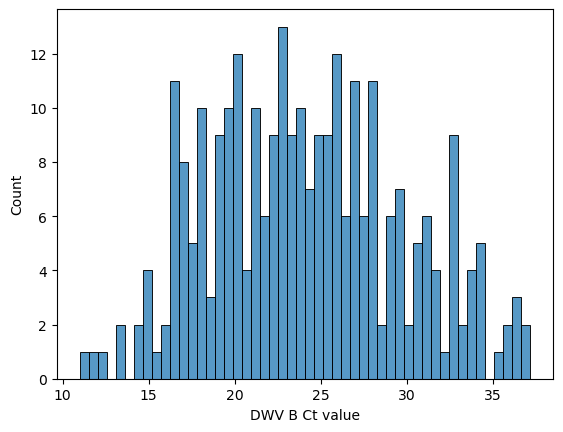

In [76]:
sns.histplot(dwvb_df['DWV B Ct value'], bins=50)

<Axes: xlabel='DWV B Ct value', ylabel='DWV B delta Ct'>

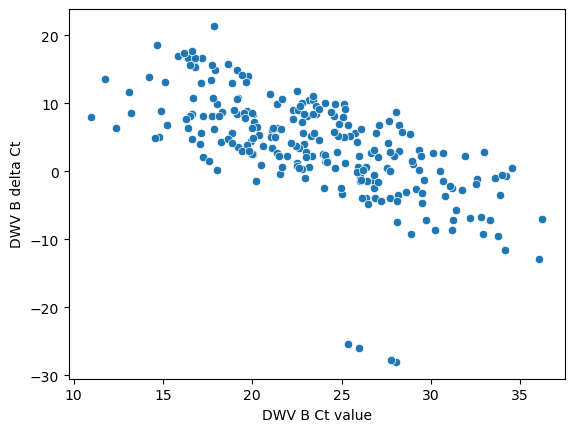

In [77]:
sns.scatterplot(data=dwvb_df, x='DWV B Ct value', y='DWV B delta Ct')

<Axes: xlabel='DWV B delta Ct', ylabel='Count'>

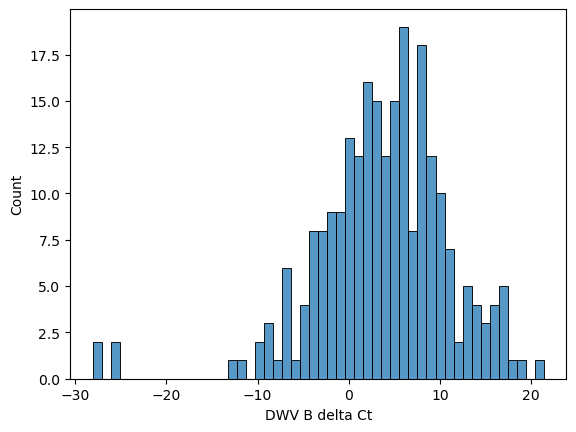

In [78]:
sns.histplot(dwvb_df['DWV B delta Ct'], bins=50)

In [79]:
dwvb_low = dwvb_df[(dwvb_df['DWV B delta Ct'] > -15) & (dwvb_df['DWV B delta Ct'] < -5)].index.to_numpy()
dwvb_med = dwvb_df[(dwvb_df['DWV B delta Ct'] > 5) & (dwvb_df['DWV B delta Ct'] < 10)].index.to_numpy()
dwvb_high = dwvb_df[(dwvb_df['DWV B delta Ct'] > 15) & (dwvb_df['DWV B delta Ct'] < 25)].index.to_numpy()

In [80]:
for a, b in product([dwvb_low, dwvb_med, dwvb_high], [mp_low, mp_med, mp_high]):
    print(set(a).intersection(b))

set()
set()
set()
{4306, 2914, 4985}
set()
set()
set()
set()
set()


In [81]:
# pick med here
set(dwvb_med).intersection(mp_low)

{2914, 4306, 4985}

In [82]:
dwvba = df_all[(df_all['DWV B Detected'] == '+') & (df_all['DWV A Detected'] == '+')].index.to_numpy()

In [83]:
#  both deformed wings variants
set(list(dwvb_high)).intersection(dwvba)

{2007}

2007: high DWV B & presence of DWV A

[2914, 4306, 4985] : med dwvb and low MP


In [84]:
na_nc_sbv = df_all[(df_all['Nosema ceranae Detected'] == '+') & (df_all['Nosema apis Detected'] == '+') & (df_all['SBV Detected'] == '+')].index.to_numpy()
na_nc_sbv

array([3974])

In [85]:
cand_samples = [2007] + [2914, 4306, 4985] + list(dwvb_low) + list(mp_med) + list(mp_high) + [3974]

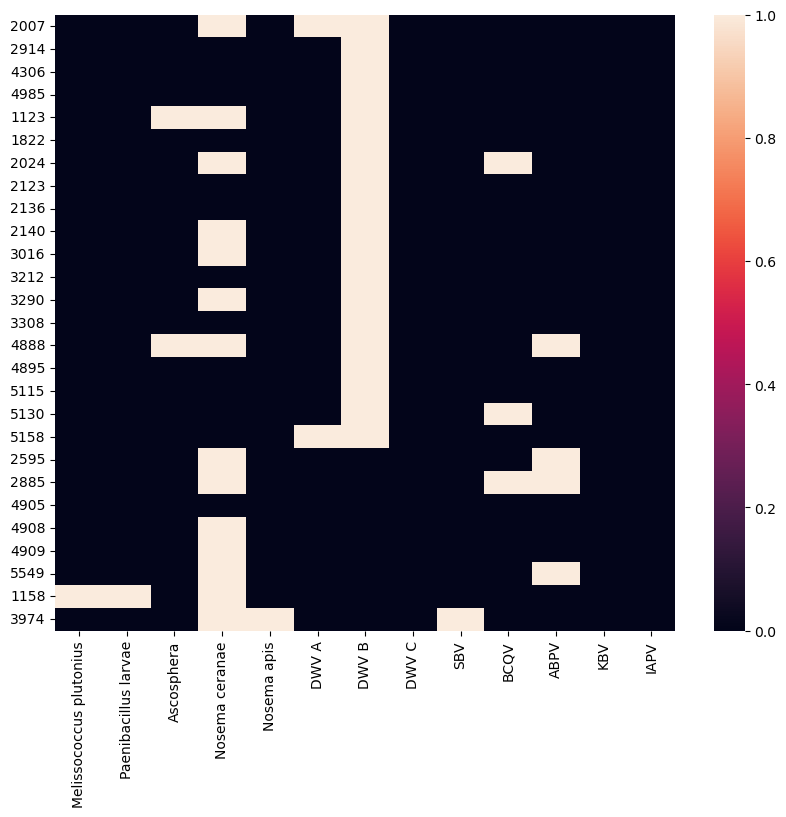

In [86]:
plt.figure(figsize=(10, 8))
cg = sns.heatmap(df_prev.iloc[cand_samples, :])
plt.show()

In [87]:
selected_samples = [2007, 2914, 4888, 2885, 1158, 3974]

In [88]:
selected_samples_df = all_df.loc[selected_samples, :]

In [90]:
selected_samples_df

,new_ideval,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen,vp/100ab,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
2007,V4R13C082019,v4R13C082019,R13,2019,C08,2018.0,2019-10-23,v4,pm,francois,D,D,0.0,colonie,390.0,0.0,9945.0,60.0,2400.0,735.0,83.349,40.0,4.536,1.64796,23.56,34.37,flat,-,flat,-,29.98,-,22.74,+,flat,-,25.86,+,18.62,15.75,+,NaN,NaN,-,25.17,NaN,-,29.32,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,8.51
2914,V3R15C052020,v3R15C052020,R15,2020,C05,2018.0,2020-08-16,v3,am,cedric,D,D,0.0,colonie,315.0,0.0,8032.5,125.0,5000.0,505.0,57.267,80.0,9.072,8.02812,25.69,31.38,37.55,-,flat,-,33.85,-,flat,-,flat,-,flat,-,22.9,8.48,+,flat,NaN,-,27.18,NaN,-,24.68,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,NaN,NaN
4888,V2R11C092022,v2R11C092022,R11,2022,C09,2021.0,2022-06-11,v2,NaN,Cédric Reymond,D,D,0.0,colonie,95.0,0.0,2422.5,0.0,0.0,115.0,13.041,0.0,0.000,NaN,27.5,23.05,flat,-,35.66,-,25.12,+,20.1,+,37.60,-,flat,-,36.03,-12.98,+,37.87,NaN,-,NaN,NaN,NaN,27.21,NaN,-,17.45,NaN,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2885,V3R12C062020,v3R12C062020,R12,2020,C06,2018.0,2020-08-18,v3,am,cedric,D,D,0.0,colonie,220.0,0.0,5610.0,40.0,1600.0,335.0,37.989,45.0,5.103,0.0,26.49,24.20,32.22,-,flat,-,25.53,-,23.18,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,28.3,NaN,-,21.49,2.71,+,30.67,-6.47,+,34.91,NaN,-,NaN,NaN,NaN,NaN
1158,V1R16C092019,v1R16C092019,R16,2019,C09,2018.0,2019-04-23,v1,pm,cedric,D,NaN,0.0,colonie,190.0,0.0,4845.0,220.0,8800.0,95.0,10.773,100.0,11.340,0.699731,25.965,NaN,27.475,+,18.99,+,27.495,-,25.27,+,flat,-,NaN,-,NaN,NaN,-,NaN,NaN,-,31.36,NaN,-,flat,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN
3974,V3R08C052021,v3R08C052020,R08,2020,C05,2018.0,2021-08-13,v3,am,gerald,D,D,0.0,colonie,1185.0,0.0,30217.5,395.0,15800.0,0.0,0.000,80.0,9.072,8.02,25.35,34.17,flat,-,flat,-,26.55,-,22.2,+,24.31,+,NaN,-,NaN,NaN,-,NaN,NaN,-,24.98,9.19,+,26.66,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN


In [91]:
melt_df_rows = []
for idx in selected_samples_df.index:
    for p in pathogens:
        new_row = []
        new_row.extend([idx, selected_samples_df.loc[idx, 'new_ideval'], p])
        for c in ['{} Ct value'.format(p), '{} delta Ct'.format(p), '{} Detected'.format(p)]:
            if c in selected_samples_df.columns:
                new_row.append(selected_samples_df.loc[idx, c])
            else:
                new_row.append(np.nan)
        melt_df_rows.append(new_row)
    

In [92]:
melt_df = pd.DataFrame(melt_df_rows, columns=['idx', 'new_ideval', 'pathogen', 'Ct value', 'Delta Ct', 'Detected'])

# filter flat or na Ct value
melt_df = melt_df[~((melt_df['Ct value'] == 'flat') | (melt_df['Ct value'].isna()))]

# filter not detected except for DWV B and M plutonius (low abundance can be untedected)
melt_df = melt_df[~((melt_df['Detected'] == '-') & ~(melt_df['pathogen'].isin({'DWV B', 'Melissococcus plutonius'})))].reset_index().drop('index', axis=1)

In [93]:
melt_df

,idx,new_ideval,pathogen,Ct value,Delta Ct,Detected
0,2007,V4R13C082019,Nosema ceranae,22.74,NaN,+
1,2007,V4R13C082019,DWV A,25.86,8.51,+
2,2007,V4R13C082019,DWV B,18.62,15.75,+
3,2914,V3R15C052020,Melissococcus plutonius,37.55,NaN,-
4,2914,V3R15C052020,DWV B,22.9,8.48,+
5,4888,V2R11C092022,Ascosphera,25.12,NaN,+
6,4888,V2R11C092022,Nosema ceranae,20.1,NaN,+
7,4888,V2R11C092022,DWV B,36.03,-12.98,+
8,4888,V2R11C092022,ABPV,17.45,NaN,+
9,2885,V3R12C062020,Melissococcus plutonius,32.22,NaN,-


In [94]:
selected_samples_df.columns

Index(['new_ideval', 'ideval', 'coderucher', 'year', 'numruche', 'anneeRuche',
       'datecoleval', 'visites', 'heurecoleval', 'evaluateur', 'typeCorps',
       'typeHausse', 'nbreHausse', 'etatColonie', 'sumPCabeilleTotal',
       'sumPHabeilleTotal', 'nbrAbeilleTotal', 'sumPCcouvfermeTotal',
       'nbrCellCouvFermeTotal', 'sumPCmiel', 'dm2miel', 'sumPCpollen',
       'dm2pollen', 'vp/100ab', 'Apis mellifera Ct value', 'βActin RT',
       'Melissococcus plutonius Ct value', 'Melissococcus plutonius Detected',
       'Paenibacillus larvae Ct value', 'Paenibacillus larvae Detected',
       'Ascosphera Ct value', 'Ascosphera Detected', 'Nosema ceranae Ct value',
       'Nosema ceranae Detected', 'Nosema apis Ct value',
       'Nosema apis Detected', 'DWV A Ct value', 'DWV A Detected',
       'DWV B Ct value', 'DWV B delta Ct', 'DWV B Detected', 'DWV C Ct value',
       'DWV C delta Ct', 'DWV C Detected', 'SBV Ct value', 'SBV delta Ct',
       'SBV Detected', 'BCQV Ct value', 'BCQV delt

In [95]:
selected_samples_df.loc[:, ['new_ideval', 'etatColonie', 'sumPCabeilleTotal',
       'sumPHabeilleTotal', 'nbrAbeilleTotal', 'sumPCcouvfermeTotal',
       'nbrCellCouvFermeTotal', 'sumPCmiel', 'dm2miel', 'sumPCpollen',
       'dm2pollen', 'vp/100ab']]

,new_ideval,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen,vp/100ab
2007,V4R13C082019,colonie,390.0,0.0,9945.0,60.0,2400.0,735.0,83.349,40.0,4.536,1.64796
2914,V3R15C052020,colonie,315.0,0.0,8032.5,125.0,5000.0,505.0,57.267,80.0,9.072,8.02812
4888,V2R11C092022,colonie,95.0,0.0,2422.5,0.0,0.0,115.0,13.041,0.0,0.000,NaN
2885,V3R12C062020,colonie,220.0,0.0,5610.0,40.0,1600.0,335.0,37.989,45.0,5.103,0.0
1158,V1R16C092019,colonie,190.0,0.0,4845.0,220.0,8800.0,95.0,10.773,100.0,11.340,0.699731
3974,V3R08C052021,colonie,1185.0,0.0,30217.5,395.0,15800.0,0.0,0.000,80.0,9.072,8.02


In [96]:
selected_samples_df['new_ideval'].to_list()

['V4R13C082019',
 'V3R15C052020',
 'V2R11C092022',
 'V3R12C062020',
 'V1R16C092019',
 'V3R08C052021']

In [97]:
vp_df[vp_df['ideval'].isin(selected_samples_df['new_ideval'].to_list())]

,new_ideval,ideval,coderucher,year,numruche,visites,vp/100ab
1198,V3R08C052021,V3R08C052021,R08,2021,C05,V3,8.02
1814,V3R12C062020,V3R12C062020,R12,2020,C06,V3,0.0
2011,V4R13C082019,V4R13C082019,R13,2019,C08,V4,1.64796
2269,V3R15C052020,V3R15C052020,R15,2020,C05,V3,8.02812
2472,V1R16C092019,V1R16C092019,R16,2019,C09,V1,0.699731
5032,V2R11C092022,V2R11C092022,R11,2022,C09,V2,NaN


In [98]:
vp_df

,new_ideval,ideval,coderucher,year,numruche,visites,vp/100ab
0,V1R01C012018,V1R01C012018,R01,2018,C01,V1,NaN
1,V2R01C012018,V2R01C012018,R01,2018,C01,V2,3.100645
2,V3R01C012018,V3R01C012018,R01,2018,C01,V3,3.537755
3,V4R01C012018,V4R01C012018,R01,2018,C01,V4,3.991047
4,V1R01C012019,V1R01C012019,R01,2019,C01,V1,0.0
...,...,...,...,...,...,...,...
300,V4R30C022023,V4R30C022023,R30,2023,C02,V4,1.376104
301,V4R30C032023,V4R30C032023,R30,2023,C03,V4,2.879377
302,V4R30C042023,V4R30C042023,R30,2023,C04,V4,2.322479
303,V4R30C052023,V4R30C052023,R30,2023,C05,V4,0.76328


In [99]:
all_df

,new_ideval,ideval,coderucher,year,numruche,anneeRuche,datecoleval,visites,heurecoleval,evaluateur,typeCorps,typeHausse,nbreHausse,etatColonie,sumPCabeilleTotal,sumPHabeilleTotal,nbrAbeilleTotal,sumPCcouvfermeTotal,nbrCellCouvFermeTotal,sumPCmiel,dm2miel,sumPCpollen,dm2pollen,vp/100ab,Apis mellifera Ct value,βActin RT,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
0,V1R01C012018,v1R01C012018,R01,2018,C01,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,440.0,0.0,9504.0,275.0,9075.0,190.0,21.546,220.0,24.948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1R01C022018,v1R01C022018,R01,2018,C02,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,175.0,0.0,3780.0,105.0,3465.0,110.0,12.474,170.0,19.278,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V1R01C032018,v1R01C032018,R01,2018,C03,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,515.0,0.0,11124.0,490.0,16170.0,300.0,34.020,215.0,24.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V1R01C042018,v1R01C042018,R01,2018,C04,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,220.0,0.0,4752.0,255.0,8415.0,240.0,27.216,120.0,13.608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,V1R01C052018,v1R01C052018,R01,2018,C05,2018.0,2018-04-20,v1,am,julie,S,NaN,0.0,NaN,680.0,0.0,14688.0,485.0,16005.0,570.0,64.638,295.0,33.453,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,V4R29C062023,v1R29C06_2023,R29,2023,C06,2018.0,2023-10-04,v4,NaN,Cédric Reymond,D,D,NaN,colonie,230.0,NaN,5865.0,95.0,3800.0,745.0,84.483,105.0,11.907,1.562005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6766,V4R29C072023,v1R29C07_2023,R29,2023,C07,2018.0,2023-10-04,v4,NaN,Cédric Reymond,D,D,NaN,colonie,330.0,NaN,8415.0,120.0,4800.0,150.0,17.010,145.0,16.443,0.354831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6767,V4R29C082023,v1R29C08_2023,R29,2023,C08,2018.0,2023-10-04,v4,NaN,Cédric Reymond,D,D,NaN,colonie,485.0,NaN,12367.5,155.0,6200.0,680.0,77.112,35.0,3.969,1.027302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6768,V4R29C092023,v1R29C09_2023,R29,2023,C09,2018.0,2023-10-04,v4,NaN,Cédric Reymond,D,D,NaN,colonie,615.0,NaN,15682.5,100.0,4000.0,775.0,87.885,15.0,1.701,1.537183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Power analyses

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.power as smp

Matplotlib created a temporary cache directory at /tmp/matplotlib-nxxu75ua because the default path (/software/anaconda3/envs/eb/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## chi-square

In [73]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [74]:
patho_nr = 1
alpha = 0.05

In [88]:
powers = np.arange(0.2, 0.8, 0.01)
effect_sizes = np.array([0.3, 0.5, 0.7])

In [89]:
n_samples = np.zeros((powers.size, effect_sizes.size))
for i, p in enumerate(powers):
    for j, e in enumerate(effect_sizes):
        n_samples[i, j] = smp.GofChisquarePower().solve_power(
            e,                                     
            n_bins=patho_nr + 1, # degree of freedom
            alpha=alpha,
            power=p)


In [90]:
df = pd.DataFrame(n_samples, columns=effect_sizes)

In [91]:
df['Power'] = powers

In [92]:
df = pd.melt(df, id_vars=['Power'], value_vars=list(effect_sizes), var_name='Effect size', value_name='Sample size')

<Axes: xlabel='Power', ylabel='Sample size'>

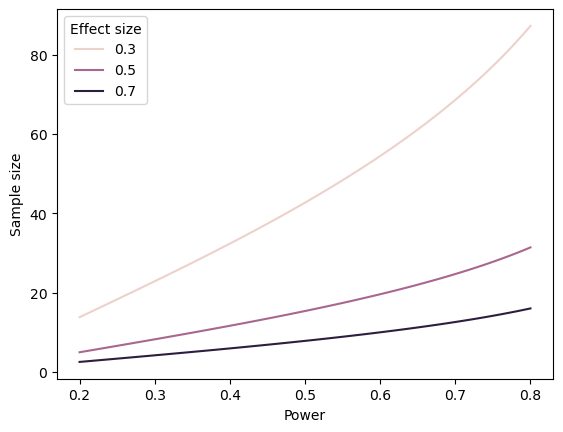

In [93]:
sns.lineplot(data=df, x='Power', y='Sample size', hue='Effect size')

In [81]:
smp.GofChisquarePower().solve_power(
    0.7,                                     
    n_bins=patho_nr + 1, # degree of freedom
    alpha=alpha,
    power=0.02)

array([10.])

# end